In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
import zipfile
import pathlib
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualizing the imageDataset

In [3]:
file = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Tensorflow Projects/Image Classification Project/Butterfly Classification/Butterfly_images.zip", "r")
file.extractall()
file.close()

In [4]:
for dirpath, dirnames, filenames in os.walk("/content/train"):
  print(f"There are {len(dirnames)} and {len(filenames)} in this {dirpath}")

There are 75 and 0 in this /content/train
There are 0 and 119 in this /content/train/SILVER SPOT SKIPPER
There are 0 and 139 in this /content/train/BANDED ORANGE HELICONIAN
There are 0 and 108 in this /content/train/METALMARK
There are 0 and 123 in this /content/train/MESTRA
There are 0 and 137 in this /content/train/MILBERTS TORTOISESHELL
There are 0 and 133 in this /content/train/EASTERN COMA
There are 0 and 139 in this /content/train/SCARCE SWALLOW
There are 0 and 105 in this /content/train/AMERICAN SNOOT
There are 0 and 112 in this /content/train/PAINTED LADY
There are 0 and 135 in this /content/train/GREAT JAY
There are 0 and 143 in this /content/train/ATALA
There are 0 and 104 in this /content/train/MALACHITE
There are 0 and 123 in this /content/train/GREY HAIRSTREAK
There are 0 and 121 in this /content/train/BLACK HAIRSTREAK
There are 0 and 129 in this /content/train/PAPER KITE
There are 0 and 108 in this /content/train/ZEBRA LONG WING
There are 0 and 109 in this /content/train/

In [5]:
path = pathlib.Path("train")
class_names = []
for i in path.glob("*"):
  class_names.append(i.name)


In [6]:
import matplotlib.image as mpimg
import random

In [7]:
def random_image(base_folder, target_folder):

  target_file = base_folder + target_folder
  random_img = random.sample(os.listdir(target_file), 1)

  img = mpimg.imread(target_file + "/" + random_img[0])
  plt.imshow(img)

  plt.title(target_folder)

  plt.axis(False)

  print(f"Image Shape : {img.shape}") 

Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)
Image Shape : (224, 224, 3)


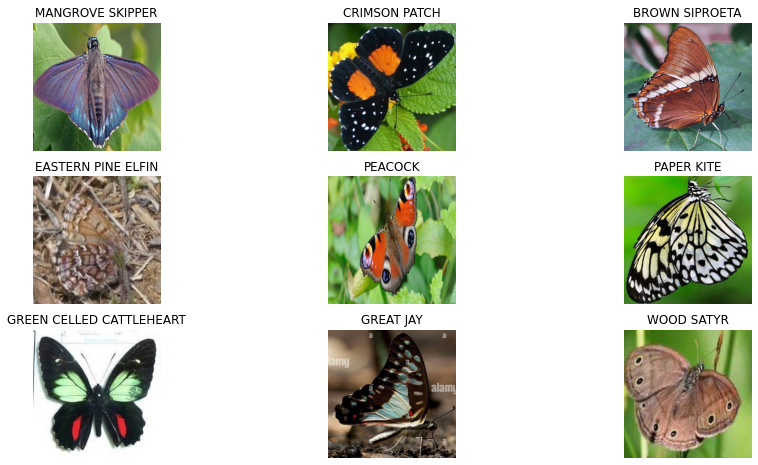

In [8]:
plt.figure(figsize = (15, 8))
for i in range(1, 10):
  plt.subplot(3, 3, i)
  random_image(base_folder = "/content/train/", target_folder = random.choice(class_names))

## PreProcessing the ImageData

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

In [10]:
train_path = "/content/train/"
validation_path = "/content/valid/"

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory= train_path, 
                                             image_size = (224, 224), 
                                             batch_size = 32, 
                                             seed = 123)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory= validation_path, 
                                             image_size = (224, 224), 
                                             batch_size = 32,
                                             shuffle = False, 
                                             seed = 123)

Found 9285 files belonging to 75 classes.
Found 375 files belonging to 75 classes.


In [12]:
class_names=train_dataset.class_names
ytrue=[]
for images, label in validation_dataset:   
    for e in label:
      ytrue.append(class_names[e])
print (len(ytrue))
print (ytrue[0])    

375
ADONIS


## Model Creation

### PreFetching

In [13]:
# It will work when you use image_dataset_from_directory

train_data = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_data = validation_dataset.prefetch(tf.data.AUTOTUNE)

### Data Augmentation

In [14]:
# # UNQ_C1
# # GRADED FUNCTION: data_augmenter
# def data_augmenter():
#     '''
#     Create a Sequential model composed of 2 layers
#     Returns:
#         tf.keras.Sequential
#     '''
#     ### START CODE HERE
#     data_augmentation = tf.keras.Sequential()
#     data_augmentation.add(RandomFlip("horizontal"))
#     data_augmentation.add(RandomRotation(0.2))
#     ### END CODE HERE
    
#     return data_augmentation

In [15]:
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [16]:
# data_aug = data_augmenter()
from tensorflow.keras import regularizers

In [19]:
def pretrained_model(model):

  base_model = model(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
  base_model.trainable = False

  input = Input(shape = (224, 224, 3))

  x = data_augmentation(input)

  x = base_model(x, training = False)

  x = GlobalAveragePooling2D(name = "pooling_layer")(x)

  x = Dense(512, activation = "relu")(x)

  x = Dropout(0.4)(x)

  x = Dense(200, activation = "relu")(x)

  output = Dense(75, activation = "softmax", name= "output_layer")(x)

  model = Model(input, output)

  return model

  # img_shape = (224, 224, 3)
  # # model_name='EfficientNetB3'
  # base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
  # x=base_model.output
  # x= BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  # x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
  #                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  # x=Dropout(rate=.45, seed=123)(x)        
  # output=Dense(len(class_labels), activation='softmax')(x)
  # model=Model(inputs=base_model.input, outputs=output)



In [20]:
model_1 = pretrained_model(model = EfficientNetB3)

# model_1.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer = "adam", 
                metrics = "accuracy")

In [21]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 pooling_layer (GlobalAverag  (None, 1536)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [22]:
initial_epoch = 10
history_1 = model_1.fit(train_dataset, 
                        epochs = initial_epoch, 
                        steps_per_epoch = len(train_dataset), 
                        validation_data = validation_dataset, 
                        validation_steps = len(validation_dataset))

Epoch 1/10
291/291 [==============================] - 150s 459ms/step - loss: 1.7496 - accuracy: 0.5399 - val_loss: 0.8022 - val_accuracy: 0.7493
Epoch 2/10
291/291 [==============================] - 109s 374ms/step - loss: 0.7187 - accuracy: 0.7830 - val_loss: 0.6381 - val_accuracy: 0.8053
Epoch 3/10
291/291 [==============================] - 91s 313ms/step - loss: 0.5499 - accuracy: 0.8305 - val_loss: 0.5016 - val_accuracy: 0.8533
Epoch 4/10
291/291 [==============================] - 90s 308ms/step - loss: 0.4981 - accuracy: 0.8478 - val_loss: 0.4871 - val_accuracy: 0.8240
Epoch 5/10
291/291 [==============================] - 85s 292ms/step - loss: 0.4356 - accuracy: 0.8676 - val_loss: 0.4718 - val_accuracy: 0.8480
Epoch 6/10
291/291 [==============================] - 78s 267ms/step - loss: 0.4086 - accuracy: 0.8717 - val_loss: 0.4425 - val_accuracy: 0.8667
Epoch 7/10
291/291 [==============================] - 73s 249ms/step - loss: 0.3759 - accuracy: 0.8808 - val_loss: 0.3731 - val_

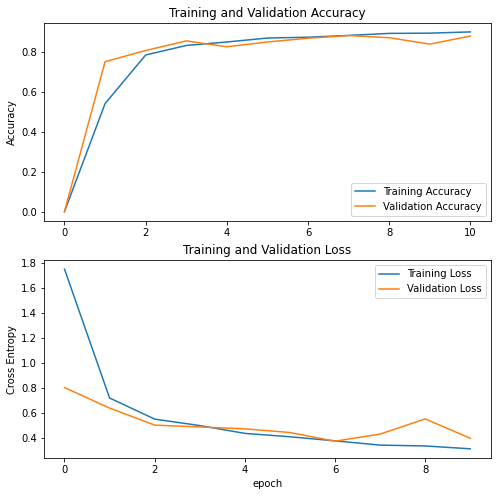

In [23]:
acc = [0.] + history_1.history['accuracy']
val_acc = [0.] + history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

In [24]:
base_model = model_1.layers[2]
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_s

In [25]:
base_model.trainable = True

In [26]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 True
1 rescaling_1 True
2 normalization_1 True
3 tf.math.truediv_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True

In [27]:
for layer in base_model.layers[:-80]:
  layer.trainable = False

In [28]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_s

In [29]:
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer = "adam", 
                metrics = "accuracy")

In [30]:
fine_tune_epochs = 5
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model_1.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_1.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
291/291 [==============================] - 91s 273ms/step - loss: 0.5581 - accuracy: 0.8354 - val_loss: 0.3676 - val_accuracy: 0.8880
Epoch 11/15
291/291 [==============================] - 71s 243ms/step - loss: 0.3534 - accuracy: 0.8970 - val_loss: 0.3668 - val_accuracy: 0.8987
Epoch 12/15
291/291 [==============================] - 74s 254ms/step - loss: 0.2897 - accuracy: 0.9158 - val_loss: 0.3934 - val_accuracy: 0.8933
Epoch 13/15
291/291 [==============================] - 71s 242ms/step - loss: 0.2579 - accuracy: 0.9233 - val_loss: 0.3326 - val_accuracy: 0.8933
Epoch 14/15
291/291 [==============================] - 69s 238ms/step - loss: 0.2538 - accuracy: 0.9270 - val_loss: 0.3639 - val_accuracy: 0.8907
Epoch 15/15
291/291 [==============================] - 68s 234ms/step - loss: 0.2162 - accuracy: 0.9360 - val_loss: 0.3452 - val_accuracy: 0.9040


In [31]:
acc += history_1.history['accuracy']
val_acc += history_1.history['val_accuracy']

loss += history_1.history['loss']
val_loss += history_1.history['val_loss']

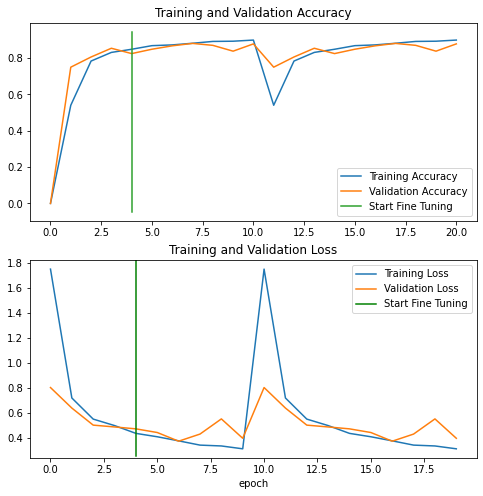

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([4, 4],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.axvline(x = 4,ymin = 0.01, color = "g", label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Making Predictions with our Model

### Finding y_test

In [33]:
class_namess=train_dataset.class_names
ytrue=[]
for images, label in validation_dataset:   
    for e in label:
      ytrue.append(class_names[e])
print (len(ytrue))
print (ytrue[0]) 

375
ADONIS


### Finding y_pred

In [35]:
from sklearn.metrics import classification_report

In [36]:
ypred=[]
errors=0
count=0
preds=model_1.predict(validation_dataset, verbose=1)
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p)
    klass=class_names[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print (msg)
ypred=np.array(ypred)
ytrue=np.array(ytrue)
print(len(ypred), len(ytrue))
print(len(class_names))
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr)    

12/12 [==============================] - 1s 124ms/step
there were 339 correct predictions in 375 tests for an accuracy of  90.40 % 
375 375
75
Classification Report:
----------------------
                            precision    recall  f1-score   support

                   ADONIS       1.00      0.80      0.89         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      0.80      0.89         5
                    ATALA       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       0.83      1.00      0.91         5
           BANDED PEACOCK       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      0.40      0.57         5
         BLACK HAIRSTREAK       0.83      1.00      0.91         5
              BLUE MORPHO       0.83      1.00      0.91         5
     

### Evaluating Model Prediction

In [37]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(ypred, ytrue)
sklearn_accuracy

0.904

In [38]:
from sklearn.metrics import classification_report
print(classification_report(ypred, ytrue))

                           precision    recall  f1-score   support

                   ADONIS       0.80      1.00      0.89         4
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.80      1.00      0.89         4
                    ATALA       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      0.83      0.91         6
           BANDED PEACOCK       1.00      1.00      1.00         5
            BECKERS WHITE       0.40      1.00      0.57         2
         BLACK HAIRSTREAK       1.00      0.83      0.91         6
              BLUE MORPHO       1.00      0.83      0.91         6
        BLUE SPOTTED CROW       0.20      1.00      0.33         1
           BROWN SIPROETA       1.00      1.00      1.00         5
            CABBAGE WHITE       1.00      0.83      0.91     

In [39]:
 # Get a dictionary of the classification report
classification_report_dict = classification_report(ypred, ytrue, output_dict=True)
classification_report_dict

{'ADONIS': {'precision': 0.8,
  'recall': 1.0,
  'f1-score': 0.888888888888889,
  'support': 4},
 'AFRICAN GIANT SWALLOWTAIL': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 5},
 'AMERICAN SNOOT': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 5},
 'AN 88': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'APPOLLO': {'precision': 0.8,
  'recall': 1.0,
  'f1-score': 0.888888888888889,
  'support': 4},
 'ATALA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'BANDED ORANGE HELICONIAN': {'precision': 1.0,
  'recall': 0.8333333333333334,
  'f1-score': 0.9090909090909091,
  'support': 6},
 'BANDED PEACOCK': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 5},
 'BECKERS WHITE': {'precision': 0.4,
  'recall': 1.0,
  'f1-score': 0.5714285714285715,
  'support': 2},
 'BLACK HAIRSTREAK': {'precision': 1.0,
  'recall': 0.8333333333333334,
  'f1-score': 0.9090909090909091,
  'support': 6},
 'BLUE MOR

In [40]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[k] = v["f1-score"]
class_f1_scores

{'ADONIS': 0.888888888888889,
 'AFRICAN GIANT SWALLOWTAIL': 1.0,
 'AMERICAN SNOOT': 1.0,
 'AN 88': 1.0,
 'APPOLLO': 0.888888888888889,
 'ATALA': 1.0,
 'BANDED ORANGE HELICONIAN': 0.9090909090909091,
 'BANDED PEACOCK': 1.0,
 'BECKERS WHITE': 0.5714285714285715,
 'BLACK HAIRSTREAK': 0.9090909090909091,
 'BLUE MORPHO': 0.9090909090909091,
 'BLUE SPOTTED CROW': 0.33333333333333337,
 'BROWN SIPROETA': 1.0,
 'CABBAGE WHITE': 0.9090909090909091,
 'CAIRNS BIRDWING': 1.0,
 'CHECQUERED SKIPPER': 1.0,
 'CHESTNUT': 0.888888888888889,
 'CLEOPATRA': 0.9090909090909091,
 'CLODIUS PARNASSIAN': 0.8000000000000002,
 'CLOUDED SULPHUR': 0.9090909090909091,
 'COMMON BANDED AWL': 0.9090909090909091,
 'COMMON WOOD-NYMPH': 1.0,
 'COPPER TAIL': 0.7692307692307693,
 'CRECENT': 0.888888888888889,
 'CRIMSON PATCH': 1.0,
 'DANAID EGGFLY': 0.33333333333333337,
 'EASTERN COMA': 0.7142857142857143,
 'EASTERN DAPPLE WHITE': 0.9090909090909091,
 'EASTERN PINE ELFIN': 0.9090909090909091,
 'ELBOWED PIERROT': 1.0,
 'GOLD 

In [41]:

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
49,PAINTED LADY,1.000000
21,COMMON WOOD-NYMPH,1.000000
24,CRIMSON PATCH,1.000000
65,SOOTYWING,1.000000
54,POPINJAY,1.000000
...,...,...
8,BECKERS WHITE,0.571429
56,PURPLISH COPPER,0.571429
25,DANAID EGGFLY,0.333333
11,BLUE SPOTTED CROW,0.333333


## Loading random Image to predict

1/1 [==============================] - 0s 57ms/step
This image most likely belongs to ADONIS 


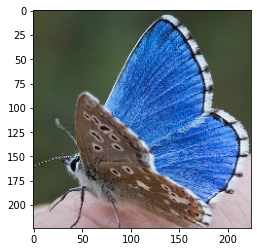

In [94]:
from matplotlib import pyplot as plt
img = tf.keras.preprocessing.image.load_img(r'/content/6 images/2.jpg',
                                            target_size=(224, 224))
img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis = 0)

score = tf.nn.softmax(model_1.predict(img_array))
print("This image most likely belongs to {} ".format(class_names[np.argmax(score)]))
plt.imshow(img)

## Testing our model for correct predictions with probabilities

In [97]:
def predict_probability():

  test_path= "/content/test"
  plt.figure(figsize=(15, 10))

  for i in range(6):
    plt.subplot(2, 3, i+1)

    # Choose a random image from a random class 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_path + "/" + class_name))
    filepath = test_path+"/" + class_name+ "/" + filename  

    # Load the image
    img = tf.keras.preprocessing.image.load_img(filepath, target_size = (224, 224))

    # Convert to Tensor
    img_tensor = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis = 0)

    # prediction
    pred_prob = model_1.predict(img_tensor)
    result_class_name = class_names[np.argmax(pred_prob)]

    # Plot the image and displaying our model prediction proability
    plt.imshow(img)
    plt.axis(False)

    if class_name == result_class_name: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"

    plt.title(f"actual: {class_name}, pred: {result_class_name}, prob: {pred_prob.max():.2f}", c=title_color)


1/1 [==============================] - 0s 29ms/step


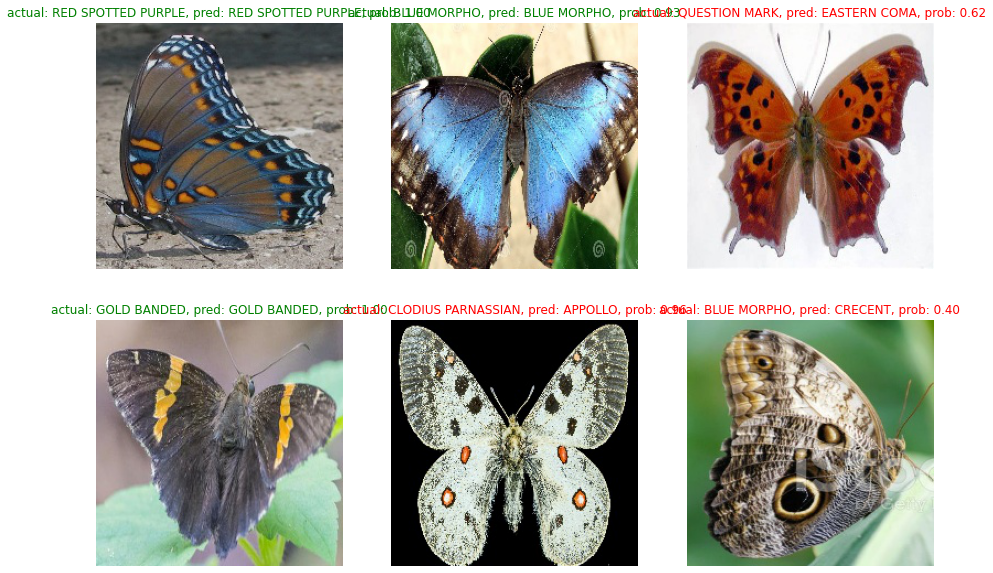

In [98]:
predict_probability()

## Finding the most wrong predictions

In [72]:
test_path= "/content/test"

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                image_size=(224, 224),
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 375 files belonging to 75 classes.


### 1. Get the filenames of all of our test data


In [74]:
filepaths = []
for filepath in test_data.list_files("test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'test/ADONIS/1.jpg',
 b'test/ADONIS/2.jpg',
 b'test/ADONIS/3.jpg',
 b'test/ADONIS/4.jpg',
 b'test/ADONIS/5.jpg',
 b'test/AFRICAN GIANT SWALLOWTAIL/1.jpg',
 b'test/AFRICAN GIANT SWALLOWTAIL/2.jpg',
 b'test/AFRICAN GIANT SWALLOWTAIL/3.jpg',
 b'test/AFRICAN GIANT SWALLOWTAIL/4.jpg',
 b'test/AFRICAN GIANT SWALLOWTAIL/5.jpg']

### 2. Create a dataframe out of current prediction data for analysis


In [76]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": ytrue,
                        "y_pred": ypred,
                        "pred_conf": preds.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [i for i in ytrue],
                        "y_pred_classname": [i for i in ypred]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'test/ADONIS/1.jpg',ADONIS,ADONIS,0.650971,ADONIS,ADONIS
1,b'test/ADONIS/2.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS
2,b'test/ADONIS/3.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS
3,b'test/ADONIS/4.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS
4,b'test/ADONIS/5.jpg',ADONIS,PURPLE HAIRSTREAK,0.594264,ADONIS,PURPLE HAIRSTREAK


### 3. Is the prediction correct?


In [77]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()


,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'test/ADONIS/1.jpg',ADONIS,ADONIS,0.650971,ADONIS,ADONIS,True
1,b'test/ADONIS/2.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS,True
2,b'test/ADONIS/3.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS,True
3,b'test/ADONIS/4.jpg',ADONIS,ADONIS,1.000000,ADONIS,ADONIS,True
4,b'test/ADONIS/5.jpg',ADONIS,PURPLE HAIRSTREAK,0.594264,ADONIS,PURPLE HAIRSTREAK,False


### 4. Get the top 100 wrong examples


In [80]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
187,b'test/JULIA/3.jpg',JULIA,BANDED ORANGE HELICONIAN,0.994177,JULIA,BANDED ORANGE HELICONIAN,False
178,b'test/INDRA SWALLOW/4.jpg',INDRA SWALLOW,YELLOW SWALLOW TAIL,0.990325,INDRA SWALLOW,YELLOW SWALLOW TAIL,False
115,b'test/CRECENT/1.jpg',CRECENT,EASTERN PINE ELFIN,0.986561,CRECENT,EASTERN PINE ELFIN,False
352,b'test/ULYSES/3.jpg',ULYSES,BLUE MORPHO,0.985485,ULYSES,BLUE MORPHO,False
269,b'test/PIPEVINE SWALLOW/5.jpg',PIPEVINE SWALLOW,ORCHARD SWALLOW,0.977563,PIPEVINE SWALLOW,ORCHARD SWALLOW,False


### 5. Visualize some of the most wrong examples


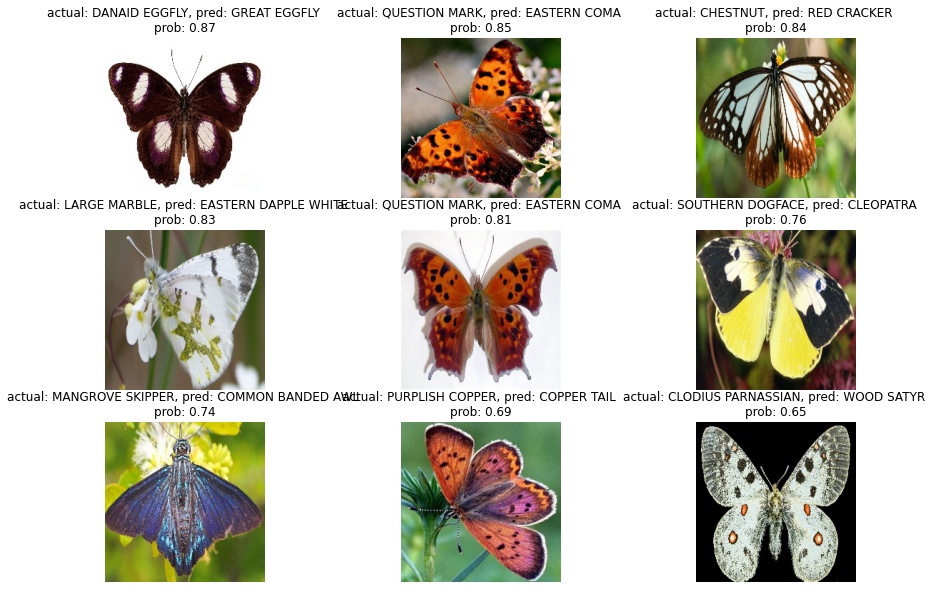

In [79]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = tf.keras.preprocessing.image.load_img(row[1], target_size = (224, 224))
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)